<a href="https://colab.research.google.com/github/NavdeepTU/Deep-Learning/blob/main/02.%20ML%20basics%20with%20Keras/03.%20Exercise_Multi_class_classification_on_Stack_Overflow_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predict the tag of a programming question on Stack Overflow

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
dataset = tf.keras.utils.get_file('stack_overflow_16k', url, untar = True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.dirname(dataset)

6053168/6053168 [==============================] - 0s 0us/step


In [3]:
os.listdir(dataset_dir)

['.config',
 'stack_overflow_16k.tar.gz',
 'train',
 'README.md',
 'test',
 'sample_data']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'python', 'java', 'javascript']

In [5]:
sample_file = os.path.join(train_dir, 'python/30.txt')
with open(sample_file) as f:
  print(f.read())

"blank script trigger a method in another script i have two scripts say script1.py on pc1 and script2.py on pc2. now, script1.py has two methods as shown below. the method1() on pc1 must be completed before method2() on pc2 can be executed. so, how can i trigger method2() of script2.py on pc2 which is already running?..i can split script2.py into two different .py files i.e method1.py and method2.py on pc2 and call method2.py after script1_method2() on pc1 has finished but then i need to pass the foo object to it. maybe i can pickle the foo object and read it from a file?..is there a better way to go about this?..note: i can communicate between pc1 and pc2 using paramiko ssh.. def script1_method1():.    """""".    this is on pc1.    get connection from pc2 script 2 and do some work.    """""".    pass..def script1_method2():.    """""".    this is on pc1.    work which needs some time.    only after this work is done, call pc2 script2.    """""".    pass..def script2_method1():.    """

Load the dataset

In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):  # taking only 1 batch
  for i in range(3):
    print('Question : ', text_batch.numpy()[i])
    print('Label : ', label_batch.numpy()[i])

Question :  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default co

In [8]:
print('Label 0 corresponds to ', raw_train_ds.class_names[0])
print('Label 1 corresponds to ', raw_train_ds.class_names[1])
print('Label 2 corresponds to ', raw_train_ds.class_names[2])
print('Label 3 corresponds to ', raw_train_ds.class_names[3])

Label 0 corresponds to  csharp
Label 1 corresponds to  java
Label 2 corresponds to  javascript
Label 3 corresponds to  python


In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size = batch_size
)

Found 8000 files belonging to 4 classes.


Prepare the dataset for training

In [11]:
def custom_standardization(input_text):
  lowercase = tf.strings.lower(input_text)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [13]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print('Review ', first_question)
print('Label ', raw_train_ds.class_names[first_label])
print('Vectorized review ', vectorize_text(first_question, first_label))

Review  tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of ext

In [16]:
print('233 --> ', vectorize_layer.get_vocabulary()[233])
print(' 21 --> ', vectorize_layer.get_vocabulary()[21])
print('Vocabulary size ', len(vectorize_layer.get_vocabulary()))

233 -->  variables
 21 -->  with
Vocabulary size  10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_train_ds.map(vectorize_text)

Configure the dataset for performance

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Create the model

In [25]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160068 (625.27 KB)
Trainable params: 160068 (625.27 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [26]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

Train the model

In [28]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/15
200/200 [==============================] - 6s 25ms/step - loss: 1.3778 - accuracy: 0.3466 - val_loss: 1.3643 - val_accuracy: 0.5031
Epoch 2/15
200/200 [==============================] - 2s 10ms/step - loss: 1.3488 - accuracy: 0.4717 - val_loss: 1.3242 - val_accuracy: 0.5788
Epoch 3/15
200/200 [==============================] - 2s 10ms/step - loss: 1.2967 - accuracy: 0.5447 - val_loss: 1.2614 - val_accuracy: 0.6162
Epoch 4/15
200/200 [==============================] - 2s 12ms/step - loss: 1.2280 - accuracy: 0.5956 - val_loss: 1.1848 - val_accuracy: 0.6678
Epoch 5/15
200/200 [==============================] - 2s 12ms/step - loss: 1.1501 - accuracy: 0.6441 - val_loss: 1.1037 - val_accuracy: 0.7086
Epoch 6/15
200/200 [==============================] - 4s 18ms/step - loss: 1.0718 - accuracy: 0.6903 - val_loss: 1.0254 - val_accuracy: 0.7412
Epoch 7/15
200/200 [==============================] - 2s 8ms/step - loss: 0.9968 - accuracy: 0.7214 - val_loss: 0.9526 - val_accuracy: 0.7581


Evaluate the model

In [29]:
loss, accuracy = model.evaluate(test_ds)

print('Loss ', loss)
print('Accuracy ', accuracy)

200/200 [==============================] - 1s 7ms/step - loss: 0.5976 - accuracy: 0.8438
Loss  0.5975771546363831
Accuracy  0.84375


Create a plot of accuracy and loss over time

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

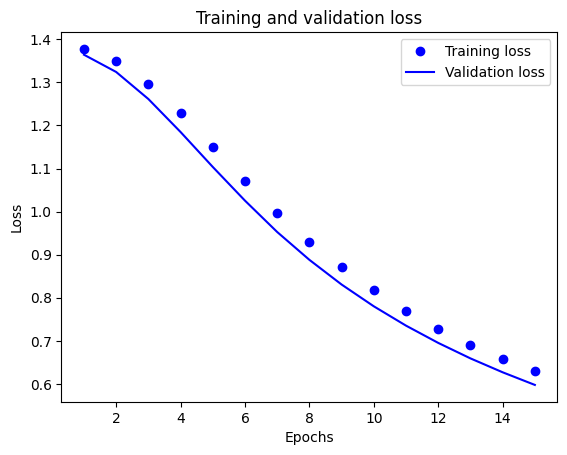

In [31]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

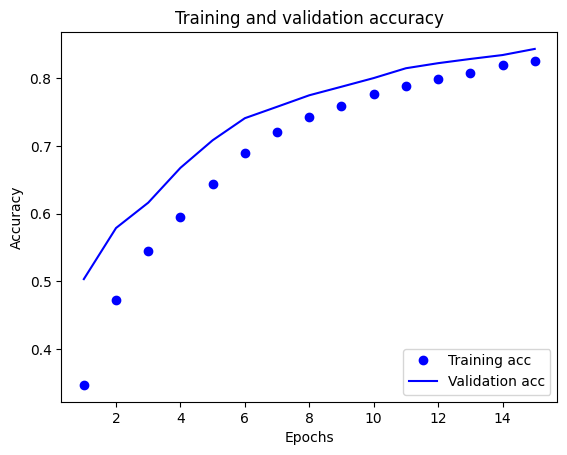

In [32]:
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')

plt.show()